# Imports

Requirements:
- python 3.6
- numpy
- matplotlib
- seaborn
- pytorch
- torchvision
- tqdm
- joblib

Note: some of the images won't show on github, but they should if you download the notebook locally and use a recent enough version of jupyter.

In [1]:
import glob
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm as tqdm
import multiprocessing
import os.path
import csv
import functools #added for resolve the problem of optimizer parameter's list empty
from meta_module import *
import copy
import joblib
from torchvision import datasets
import torchvision
import seaborn as sns; sns.set(color_codes=True)
sns.set_style("white")
from pdb import set_trace as bp

In [2]:
USE_CUDA = torch.cuda.is_available()

def w(v):
    if USE_CUDA:
        return v.cuda()
    return v


In [3]:
!mkdir -p _cache
cache = joblib.Memory(location='_cache', verbose=0)

A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file _cache already exists.
Error occurred while processing: _cache.


# Intro

This notebook is a reproduction of the paper "Learning to Learn by Gradient Descent by Gradient Descent" (https://arxiv.org/abs/1606.04474). 

In a word, this paper is trying to replace the optimizers normally used for neural networks (eg Adam, RMSprop, SGD etc.) by a recurrent neural network: after all, gradient descent is fundamentally a **sequence** of updates (from the output layer of the neural net back to the input), in between which a **state** must be stored. Thus we can think of an optimizer as a mini-RNN. The idea in this paper is to actually train that RNN instead of using a generic algorithm like Adam/SGD/etc..

## Loss

The loss function described in the paper seems complicated, but in reality it is very simple: all it is saying is that the loss of the optimizer is the sum of the losses of the optimizee as it learns. The paper includes some notion of weighing but gives a weight of 1 to everything, so that it indeed is just the sum.

$$\mathcal{L}(\phi) = \mathbb{E}_f \left[ \sum_{t=1}^T w_t f(\theta_t) \right]$$
where
$$\theta_{t+1} = \theta_t + g_t$$
$$\begin{bmatrix} g_t \\ h_{t+1} \end{bmatrix} = m(\nabla_t, h_t, \phi)$$

The $w_t$ are arbitrary weights for each timestep. If we only set the last $w_t$ to 1 and the rest to 0, we are optimizing for the best **final** result with our optimizee. This seems reasonable, but it makes it much harder to train. Instead we will use $w_t$ = 1 for all $t$. $\nabla_t = \nabla_{\theta} f(\theta_t)$.

$f$ is the *optimizee* function, and $\theta_t$ is its parameters at time $t$.
$m$ is the *optimizer* function, $\phi$ is its parameters. $h_t$ is its state at time $t$. $g_t$ is the update it outputs at time $t$.

The plan is thus to use gradient descent on $\phi$ in order to minimize $\mathcal{L}(\phi)$, which should give us an optimizer that is capable of optimizing $f$ efficiently.

As the paper mention, it is important that the gradients in dashed lines in the figure below are **not** propagated during gradient descent.

![image.png](attachment:image.png)

Basically this is nothing we wouldn't expect: the loss of the optimizer neural net is simply the average training loss of the optimizee as it is trained by the optimizer. The optimizer takes in the gradient of the current coordinate of the optimizee as well as its previous state, and outputs a suggested update that we hope will reduce the optimizee's loss as fast as possible.

## Coordinatewise

Informally speaking, coordinatewise optimization is to optimize each parameter by its own state. Any momentum or energy term used in the optimization is based on each parameter's own history, independent on others. Each parameter's optimization state is not shared across other coordinates.

The precondition assumed in ths paper, is that all parameters share the same weights in the LSTM meta optimizer.

# Implementation

As we perform operations, Pytorch builds the computational graph of the operations we perform. However, there are some variables that we want to detach from the graph at various points, specifically we want to pretend that the gradients are inputs (as specified in the previous image) that come from nowhere, instead of coming from the rest of the computational graph as they really do: this means we want to **detach** the gradients from the graph. Likewise, when every 20 steps we perform backpropagation on the optimizer network, we want the current hidden states and cell states, as well as the parameters of the optimizee to "forget" that they are dependent on previous steps in the graph. For all of this, I created a function called `detach_var` which creates a new Variable from the current variable's data, and makes sure that its gradients are still kept. This is different from the `.detach()` function in Pytorch which does not quite forget the original graph and also does not guarantee that the gradients will be there.

In [4]:
def detach_var(v):
    var = w(Variable(v.data, requires_grad=True))
    var.retain_grad()
    return var



def rsetattr(obj, attr, val):
    pre, _, post = attr.rpartition('.')
    return setattr(rgetattr(obj, pre) if pre else obj, post, val)

# using wonder's beautiful simplification: https://stackoverflow.com/questions/31174295/getattr-and-setattr-on-nested-objects/31174427?noredirect=1#comment86638618_31174427

def rgetattr(obj, attr, *args):
    def _getattr(obj, attr):
        return getattr(obj, attr, *args)
    return functools.reduce(_getattr, [obj] + attr.split('.'))

def do_fit(opt_net, meta_opt, target_cls, target_to_opt, unroll, optim_it, n_epochs, out_mul, should_train=True):
    if should_train:
        opt_net.train()
    else:
        opt_net.eval()
        unroll = 1
    
    target = target_cls(training=should_train)
    optimizee = w(target_to_opt())
    n_params = 0
    for name, p in optimizee.all_named_parameters():
        n_params += int(np.prod(p.size()))
    hidden_states = [w(Variable(torch.zeros(n_params, opt_net.hidden_sz))) for _ in range(2)]
    cell_states = [w(Variable(torch.zeros(n_params, opt_net.hidden_sz))) for _ in range(2)]
    all_losses_ever = []
    if should_train:
        meta_opt.zero_grad()
    all_losses = None
    for iteration in range(1, optim_it + 1):
        loss = optimizee(target)
                    
        if all_losses is None:
            all_losses = loss
        else:
            all_losses += loss
        
        all_losses_ever.append(loss.data.cpu().numpy())
        loss.backward(retain_graph=should_train)

        offset = 0
        result_params = {}
        hidden_states2 = [w(Variable(torch.zeros(n_params, opt_net.hidden_sz))) for _ in range(2)]
        cell_states2 = [w(Variable(torch.zeros(n_params, opt_net.hidden_sz))) for _ in range(2)]
        for name, p in optimizee.all_named_parameters():
            cur_sz = int(np.prod(p.size()))
            # We do this so the gradients are disconnected from the graph but we still get
            # gradients from the rest
            gradients = detach_var(p.grad.view(cur_sz, 1))
            updates, new_hidden, new_cell = opt_net(
                gradients,
                [h[offset:offset+cur_sz] for h in hidden_states],
                [c[offset:offset+cur_sz] for c in cell_states]
            )
            for i in range(len(new_hidden)):
                hidden_states2[i][offset:offset+cur_sz] = new_hidden[i]
                cell_states2[i][offset:offset+cur_sz] = new_cell[i]
            result_params[name] = p + updates.view(*p.size()) * out_mul
            result_params[name].retain_grad()
            
            offset += cur_sz
            
        if iteration % unroll == 0:
            if should_train:
                meta_opt.zero_grad()
                all_losses.backward()
                meta_opt.step()
                
            all_losses = None

            optimizee = w(target_to_opt())
            optimizee.load_state_dict(result_params)
            optimizee.zero_grad()
            hidden_states = [detach_var(v) for v in hidden_states2]
            cell_states = [detach_var(v) for v in cell_states2]
            
        else:
            for name, p in optimizee.all_named_parameters():
                rsetattr(optimizee, name, result_params[name])
            assert len(list(optimizee.all_named_parameters()))
            hidden_states = hidden_states2
            cell_states = cell_states2
            
    return all_losses_ever


@cache.cache
def fit_optimizer(target_cls, target_to_opt, preproc=False, unroll=20, optim_it=100, n_epochs=20, n_tests=100, lr=0.001, out_mul=1.0):
    # do_fit(opt_net, meta_opt, target_cls, target_to_opt, unroll, optim_it, n_epochs, out_mul, should_train=True):
    opt_net = w(Optimizer(preproc=preproc))
    meta_opt = optim.Adam(opt_net.parameters(), lr=lr)
    
    best_net = None
    best_loss = 100000000000000000
    
    for _ in tqdm(range(n_epochs), 'epochs'):
        for _ in tqdm(range(20), 'iterations'):
            do_fit(opt_net, meta_opt, target_cls, target_to_opt, unroll, optim_it, n_epochs, out_mul, should_train=True)
        
        loss = (np.mean([
            np.sum(do_fit(opt_net, meta_opt, target_cls, target_to_opt, unroll, optim_it, n_epochs, out_mul, should_train=False))
            for _ in tqdm(range(n_tests), 'tests')
        ]))
        print(loss)
        if loss < best_loss:
            print(best_loss, loss)
            best_loss = loss
            best_net = copy.deepcopy(opt_net.state_dict())
            
    return best_loss, best_net
  


# Experiment repro

## Quadratic functions

These are pretty simple: our optimizer is supposed to find a 10-element vector called $\theta$ that, when multiplied by a 10x10 matrix called $W$, is as close as possible to a 10-element vector called $y$. Both $y$ and $W$ are generated randomly. The error is simply the squared error.

In [5]:
class QuadraticLoss:
    def __init__(self, **kwargs):
        self.W = w(Variable(torch.randn(10, 10)))
        self.y = w(Variable(torch.randn(10)))
        
    def get_loss(self, theta):
        return torch.sum((self.W.matmul(theta) - self.y)**2)
    
class QuadOptimizee(MetaModule):
    def __init__(self, theta=None):
        super().__init__()
        self.register_buffer('theta', to_var(torch.zeros(10).cuda(), requires_grad=True))
        
    def forward(self, target):
        return target.get_loss(self.theta)

    def named_leaves(self):
        return self.all_named_parameters()
    
    def all_named_parameters(self):
        return [('theta', self.theta)]
        
class Optimizer(MetaModule):
    def __init__(self, preproc=False, hidden_sz=20, preproc_factor=10.0):
        super().__init__()
        self.hidden_sz = hidden_sz
        if preproc:
            self.recurs = nn.LSTMCell(2, hidden_sz)
        else:
            self.recurs = nn.LSTMCell(1, hidden_sz)
        self.recurs2 = nn.LSTMCell(hidden_sz, hidden_sz)
        self.output = MetaLinear(hidden_sz, 1)
        self.preproc = preproc
        self.preproc_factor = preproc_factor
        self.preproc_threshold = np.exp(-preproc_factor)
        
    def forward(self, inp, hidden, cell):
        if self.preproc:
            # Implement preproc described in Appendix A
            
            # Note: we do all this work on tensors, which means
            # the gradients won't propagate through inp. This
            # should be ok because the algorithm involves
            # making sure that inp is already detached.
            inp = inp.data
            inp2 = w(torch.zeros(inp.size()[0], 2))
            keep_grads = (torch.abs(inp) >= self.preproc_threshold).squeeze()
            inp2[:, 0][keep_grads] = (torch.log(torch.abs(inp[keep_grads]) + 1e-8) / self.preproc_factor).squeeze()
            inp2[:, 1][keep_grads] = torch.sign(inp[keep_grads]).squeeze()
            
            inp2[:, 0][~keep_grads] = -1
            inp2[:, 1][~keep_grads] = (float(np.exp(self.preproc_factor)) * inp[~keep_grads]).squeeze()
            inp = w(Variable(inp2))
        hidden0, cell0 = self.recurs(inp, (hidden[0], cell[0]))
        hidden1, cell1 = self.recurs2(hidden0, (hidden[1], cell[1]))
        return self.output(hidden1), (hidden0, hidden1), (cell0, cell1)
    

> Each function was optimized for 100 steps and the trained optimizers were unrolled for 20 steps.

I assume this means that each epoch is made up of trying to optimize a
new random function for 100 steps, but we are doing an update of the
optimizer every 20 steps. The number of epochs is thus unspecified, but
according to the graphs it seems to be 100 too.

The experiment below on the various learning rates show that 0.003 is a promising learning rate (it is not the lowest, but we are training on only 20 epochs by default and will then retrain with 100 epochs, so it is good to have a slightly lower learning rate for training for longer). We train our final model using 0.003.

In [11]:
for lr in tqdm([1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001], 'all'):
    print('Trying lr:', lr)
    print(fit_optimizer(QuadraticLoss, QuadOptimizee, lr=lr)[0])

Trying lr: 1.0


KeyboardInterrupt: 

In [8]:
loss, quad_optimizer = fit_optimizer(QuadraticLoss, QuadOptimizee, lr=0.003, n_epochs=100)
print(loss)

C:\Users\tiany\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:102: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


C:\Users\tiany\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:103: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


C:\Users\tiany\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:108: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



166.19469
100000000000000000 166.19469



135.97108
166.19469 135.97108



130.71497
135.97108 130.71497



118.98361
130.71497 118.98361



111.58239
118.98361 111.58239



118.45816



123.54718



112.44145



87.49596
111.58239 87.49596



100.05601



102.75515



97.21418



97.39503



91.84299



91.014275



104.99096



95.211716



88.992386



96.48965



75.4156
87.49596 75.4156



84.6109



85.123955



65.20251
75.4156 65.20251



67.06319



62.094288
65.20251 62.094288



71.487404



78.05037



80.823845



71.773476



67.697105



81.300514



66.551414



78.88659



128.41832



107.854805



113.85725



116.377594



87.57786



84.094246



94.0658



73.55049



80.21733



68.328445



66.5485



67.64222



61.065147
62.094288 61.065147



62.709435



67.3324



70.107155



55.65967
61.065147 55.65967



64.02601



53.986534
55.65967 53.986534



69.27876



80.318436



72.73233



72.648605



54.812977



63.29051



67.83211



69.57147



68.00259



61.72484



76.05696



86.530716



60.598633



54.513374



55.15022



77.68589



67.879745



77.58462



67.37588



87.43545



69.46768



48.19523
53.986534 48.19523



67.35285



60.056095



96.1943



89.152626



76.456635



82.21545



81.42654



70.33509



64.10296



67.59461



74.554985



68.741844



71.28415



77.70625



91.315994



73.72778



74.537415



62.139385



63.497993



59.249004



70.52124



67.91203



58.28411



47.446915
48.19523 47.446915



53.90369



60.909035

47.446915


Now we need to find the best learning rate for the various comparison optimizers. We end up finding 0.1 for Adam, 0.03 for RMSprop, 0.01 for SGD and 0.01 for SGD with nesterov momentum (aka NAG).

In [9]:
@cache.cache
def fit_normal(target_cls, target_to_opt, opt_class, n_tests=100, n_epochs=100, **kwargs):
    results = []
    for i in tqdm(range(n_tests), 'tests'):
        target = target_cls(training=False)
        optimizee = w(target_to_opt())
        optimizer = opt_class(optimizee.parameters(), **kwargs)
        total_loss = []
        for _ in range(n_epochs):
            loss = optimizee(target)
            
            total_loss.append(loss.data.cpu().numpy())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        results.append(total_loss)
    return results

def find_best_lr_normal(target_cls, target_to_opt, opt_class, **extra_kwargs):
    best_loss = 1000000000000000.0
    best_lr = 0.0
    for lr in tqdm([1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001], 'Learning rates'):
        try:
            loss = best_loss + 1.0
            loss = np.mean([np.sum(s) for s in fit_normal(target_cls, target_to_opt, opt_class, lr=lr, **extra_kwargs)])
        except RuntimeError:
            pass
        if loss < best_loss:
            best_loss = loss
            best_lr = lr
    return best_loss

In [10]:
NORMAL_OPTS = [(optim.Adam, {}), (optim.RMSprop, {}), (optim.SGD, {'momentum': 0.9}), (optim.SGD, {'nesterov': True, 'momentum': 0.9})]
OPT_NAMES = ['ADAM', 'RMSprop', 'SGD', 'NAG']

In [11]:
# NB: the momentum parameter for nesterov was found from the following file: https://github.com/torch/optim/blob/master/nag.lua
# since it is mentioned in the paper that "When an optimizer has more parameters than just a learning rate (e.g. decay coefficients for ADAM) we use the default values from the optim package in Torch7."
for opt, kwargs in NORMAL_OPTS:
    print(find_best_lr_normal(QuadraticLoss, QuadOptimizee, opt, **kwargs))

C:\Users\tiany\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


C:\Users\tiany\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


C:\Users\tiany\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Persisting input arguments took 0.97s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.


C:\Users\tiany\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Persisting input arguments took 0.56s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.


C:\Users\tiany\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Persisting input arguments took 0.64s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.


C:\Users\tiany\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Persisting input arguments took 0.65s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.


C:\Users\tiany\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Persisting input arguments took 0.53s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.


C:\Users\tiany\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Persisting input arguments took 0.58s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.




106.952805


C:\Users\tiany\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Persisting input arguments took 0.51s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.


C:\Users\tiany\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Persisting input arguments took 0.52s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.




113.80061


C:\Users\tiany\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Persisting input arguments took 0.57s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.


C:\Users\tiany\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Persisting input arguments took 0.62s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.




109.40193


C:\Users\tiany\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Persisting input arguments took 0.55s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.


C:\Users\tiany\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Persisting input arguments took 0.78s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
C:\Users\tiany\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


C:\Users\tiany\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:26: UserWarning: Persisting input arguments took 0.67s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.




100.7716


In [12]:
QUAD_LRS = [0.1, 0.03, 0.01, 0.01]
fit_data = np.zeros((100, 100, len(OPT_NAMES) + 1))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(QuadraticLoss, QuadOptimizee, opt, lr=lr, **extra_kwargs))

opt = w(Optimizer())
opt.load_state_dict(quad_optimizer)
np.random.seed(0)
fit_data[:, :, len(OPT_NAMES)] = np.array([do_fit(opt, None, QuadraticLoss, QuadOptimizee, 1, 100, 100, out_mul=1.0, should_train=False) for _ in range(100)])

Finally we plot the learning curve for LSTM vs the different alternatives. For reference, the plot in the paper looks like this:

![image.png](attachment:image.png)

Our result is pretty similar.

C:\Users\tiany\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


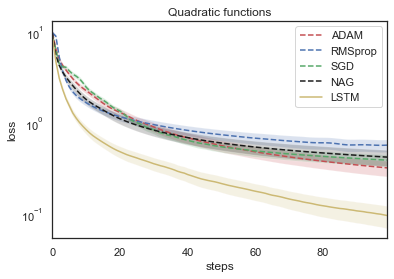

In [13]:
ax = sns.tsplot(data=fit_data[:,:,:], condition=OPT_NAMES + ['LSTM'], linestyle='--', color=['r', 'b', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('Quadratic functions')
plt.show()

## MNIST

Now we move on to MNIST. Because all the rest of our code is implemented, we just need to implement the network specified in the paper, namely a single hidden layer, sigmoid, 20 hidden units network. We make it easy to change sigmoid to some other activation, add layers, and change the number of units, because all of these are attempted in the paper.

In [6]:
class MNISTLoss:
    def __init__(self, training=True):
        dataset = datasets.MNIST(
            'mnist', train=True, download=True,
            transform=torchvision.transforms.ToTensor()
        )
        indices = list(range(len(dataset)))
        np.random.RandomState(10).shuffle(indices)
        if training:
            indices = indices[:len(indices) // 2]
        else:
            indices = indices[len(indices) // 2:]

        self.loader = torch.utils.data.DataLoader(
            dataset, batch_size=128,
            sampler=torch.utils.data.sampler.SubsetRandomSampler(indices),
            num_workers=10
        )

        self.batches = []
        self.cur_batch = 0
        
    def sample(self):
        if self.cur_batch >= len(self.batches):
            self.batches = []
            self.cur_batch = 0
            for b in self.loader:
                self.batches.append(b)
        batch = self.batches[self.cur_batch]
        self.cur_batch += 1
        return batch

class MNISTNet(MetaModule):
    def __init__(self, layer_size=20, n_layers=1, **kwargs):
        super().__init__()

        inp_size = 28*28
        self.layers = {}
        for i in range(n_layers):
            self.layers[f'mat_{i}'] = MetaLinear(inp_size, layer_size)
            inp_size = layer_size

        self.layers['final_mat'] = MetaLinear(inp_size, 10)
        self.layers = ModuleDict(self.layers)

        self.activation = nn.Sigmoid()
        self.loss = nn.NLLLoss()
    
    #Added method to resolve the problem of parameters empty 
    def all_named_parameters(self):
        return [(k, v) for k, v in self.named_parameters()]
    
    def forward(self, loss):
        inp, out = loss.sample()
        inp = w(Variable(inp.view(inp.size()[0], 28*28)))
        out = w(Variable(out))
        cur_layer = 0
        while f'mat_{cur_layer}' in self.layers:
            inp = self.activation(self.layers[f'mat_{cur_layer}'](inp))
            cur_layer += 1

        inp = F.log_softmax(self.layers['final_mat'](inp), dim=1)
        l = self.loss(inp, out)
        return l

Like before, we find a promising learning rate (0.001) using a small number of epochs (10) and optimize it fully using more epochs (50).

In [8]:
for lr in tqdm(sorted([1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001], key=lambda x: np.abs(x - 0.003)), 'all'):
    print('Trying lr:', lr)
    print(fit_optimizer(MNISTLoss, MNISTNet, lr=lr, out_mul=0.1, preproc=True, n_tests=5, n_epochs=10)[0])

C:\Users\tiany\AppData\Local\Temp/ipykernel_15768/949940538.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for lr in tqdm(sorted([1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001], key=lambda x: np.abs(x - 0.003)), 'all'):


all:   0%|          | 0/11 [00:00<?, ?it/s]

Trying lr: 0.003


C:\Users\tiany\AppData\Local\Temp/ipykernel_15768/289615635.py:102: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm(range(n_epochs), 'epochs'):


epochs:   0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\tiany\AppData\Local\Temp/ipykernel_15768/289615635.py:103: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _ in tqdm(range(20), 'iterations'):


iterations:   0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist\MNIST\raw\train-images-idx3-ubyte.gz to mnist\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist\MNIST\raw\train-labels-idx1-ubyte.gz to mnist\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist\MNIST\raw\t10k-images-idx3-ubyte.gz to mnist\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist\MNIST\raw\t10k-labels-idx1-ubyte.gz to mnist\MNIST\raw



RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "C:\ProgramData\Miniconda3\envs\py310\lib\site-packages\torch\utils\data\_utils\worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "C:\ProgramData\Miniconda3\envs\py310\lib\site-packages\torch\utils\data\_utils\fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "C:\ProgramData\Miniconda3\envs\py310\lib\site-packages\torch\utils\data\_utils\fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "C:\ProgramData\Miniconda3\envs\py310\lib\site-packages\torchvision\datasets\mnist.py", line 142, in __getitem__
    img = Image.fromarray(img.numpy(), mode="L")
RuntimeError: Numpy is not available


In [ ]:
loss, mnist_optimizer = fit_optimizer(MNISTLoss, MNISTNet, lr=0.01, n_epochs=5, n_tests=20, out_mul=0.1, preproc=True)
print(loss)

We find the best learning rates for the competitors...

In [ ]:
for opt, kwargs in NORMAL_OPTS:
    print(find_best_lr_normal(MNISTLoss, MNISTNet, opt, **kwargs, n_tests=10))
    

And plot! for context, the graph in the original paper looks like this:

![image.png](attachment:image.png)

Again we get similar results!!!

In [ ]:
QUAD_LRS = [0.03, 0.01, 1.0, 1.0]

N_TESTS = 100

fit_data = np.zeros((N_TESTS, 200, len(OPT_NAMES) + 1))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(MNISTLoss, MNISTNet, opt, lr=lr, n_tests=N_TESTS, n_epochs=200, **extra_kwargs))

In [ ]:
@cache.cache
def get_fit_dict_test(n_tests, opt_dict, *args, **kwargs):
    opt = w(Optimizer(preproc=True))
    opt.load_state_dict(opt_dict)
    np.random.seed(0)
    return [do_fit(opt, *args, **kwargs) for _ in tqdm(range(N_TESTS), 'optimizer')]

fit_data[:, :, len(OPT_NAMES)] = np.array(get_fit_dict_test(N_TESTS, mnist_optimizer, None, MNISTLoss, MNISTNet, 1, 200, 200, out_mul=0.1, should_train=False))

In [ ]:
ax = sns.tsplot(data=fit_data[:, :, :], condition=OPT_NAMES + ['LSTM'], linestyle='--', color=['r', 'b', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('MNIST')
plt.show()

In [ ]:
class MNISTNet2Layer(MNISTNet):
    def __init__(self, *args, **kwargs):
        super().__init__(n_layers=2, *args, **kwargs)
        
class MNISTNetBig(MNISTNet):
    def __init__(self, *args, **kwargs):
        super().__init__(layer_size=40, *args, **kwargs)
        
class MNISTRelu(MNISTNet):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.activation = nn.ReLU()

In [ ]:
for opt, kwargs in NORMAL_OPTS:
    print(find_best_lr_normal(MNISTLoss, MNISTNet2Layer, opt, **kwargs, n_tests=10))
for opt, kwargs in NORMAL_OPTS:
    print(find_best_lr_normal(MNISTLoss, MNISTNetBig, opt, **kwargs, n_tests=10))
for opt, kwargs in NORMAL_OPTS:
    print(find_best_lr_normal(MNISTLoss, MNISTRelu, opt, **kwargs, n_tests=10))


Same as above, for a 2 layer network. Again LSTM does great even though it was trained on a single layer network, and again we are similar to the paper:

![image.png](attachment:image.png)

In [ ]:
QUAD_LRS = [0.01, 0.003, 0.03, 1.0]
N_TESTS = 100

fit_data = np.zeros((N_TESTS, 200, len(OPT_NAMES) + 1))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(MNISTLoss, MNISTNet2Layer, opt, lr=lr, n_tests=N_TESTS, n_epochs=200, **extra_kwargs))

fit_data[:, :, len(OPT_NAMES)] = np.array(get_fit_dict_test(N_TESTS, mnist_optimizer, None, MNISTLoss, MNISTNet2Layer, 1, 200, 200, out_mul=0.1, should_train=False))

In [ ]:
ax = sns.tsplot(data=fit_data[:, :, :], condition=OPT_NAMES + ['LSTM'], linestyle='--', color=['r', 'b', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('MNIST (2 layers)')
plt.show()

Same as above but for a single layer, 40 hidden unit network.

Paper comparison:
![image.png](attachment:image.png)

In [ ]:
QUAD_LRS = [0.03, 0.01, 1.0, 1.0]

N_TESTS = 100

fit_data = np.zeros((N_TESTS, 200, len(OPT_NAMES) + 1))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(MNISTLoss, MNISTNetBig, opt, lr=lr, n_tests=N_TESTS, n_epochs=200, **extra_kwargs))

fit_data[:, :, len(OPT_NAMES)] = np.array(get_fit_dict_test(N_TESTS, mnist_optimizer, None, MNISTLoss, MNISTNetBig, 1, 200, 200, out_mul=0.1, should_train=False))

In [ ]:
ax = sns.tsplot(data=fit_data[:, :, :], condition=OPT_NAMES + ['LSTM'], linestyle='--', color=['r', 'b', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('MNIST (40 hidden units)')
plt.show()

Finally, same as above but with ReLU. As we shall see, the optimizer doesn't generalize very well to a different activation function, and so the other optimizers do much better. My reproduction shows this too although strangely my optimizer seems to do better than the one from the paper.

Original:
![image.png](attachment:image.png)

In [ ]:
QUAD_LRS = [0.03, 0.003, 0.3, 0.3]
N_TESTS = 100


fit_data = np.zeros((N_TESTS, 200, len(OPT_NAMES) + 1))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data[:, :, i] = np.array(fit_normal(MNISTLoss, MNISTRelu, opt, lr=lr, n_tests=N_TESTS, n_epochs=200, **extra_kwargs))

fit_data[:, :, len(OPT_NAMES)] = np.array(get_fit_dict_test(N_TESTS, mnist_optimizer, None, MNISTLoss, MNISTRelu, 1, 200, 200, out_mul=0.1, should_train=False))

In [ ]:
ax = sns.tsplot(data=fit_data[:, :, :], condition=OPT_NAMES + ['LSTM'], linestyle='--', color=['r', 'b', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('MNIST (ReLU)')
plt.show()

# CIFAR1O 
As it was in the paper we decided to test CIFAR10 datasets

In [ ]:
class CIFAR10Loss:
    def __init__(self, training=True):
        resize = torchvision.transforms.Resize(28)
        to_tensor = torchvision.transforms.ToTensor()
        gray_scale = torchvision.transforms.Grayscale()
        dataset = datasets.CIFAR10(
            'cifar10', train=True, download=True,
            transform=torchvision.transforms.Compose([resize,gray_scale,to_tensor]) 
        )
        indices = list(range(len(dataset)))
        np.random.RandomState(10).shuffle(indices)
        if training:
            indices = indices[:len(indices) // 2]
        else:
            indices = indices[len(indices) // 2:]

        self.loader = torch.utils.data.DataLoader(
            dataset, batch_size=128,
            sampler=torch.utils.data.sampler.SubsetRandomSampler(indices))

        self.batches = []
        self.cur_batch = 0
        
    def sample(self):
        if self.cur_batch >= len(self.batches):
            self.batches = []
            self.cur_batch = 0
            for b in self.loader:
                self.batches.append(b)
        batch = self.batches[self.cur_batch]
        self.cur_batch += 1
        return batch

class CIFAR10Net(MetaModule):
    def __init__(self, layer_size=20, n_layers=1, **kwargs):
        super().__init__()

        inp_size = 28*28
        self.layers = {}
        for i in range(n_layers):
            self.layers[f'mat_{i}'] = MetaLinear(inp_size, layer_size)
            inp_size = layer_size

        self.layers['final_mat'] = MetaLinear(inp_size, 10)
        self.layers = ModuleDict(self.layers)

        self.activation = nn.Sigmoid()
        self.loss = nn.NLLLoss()

    def all_named_parameters(self):
        return [(k, v) for k, v in self.named_parameters()]
    
    def forward(self, loss):
        inp, out = loss.sample()
        inp = w(Variable(inp.view(inp.size()[0], 28*28)))
        out = w(Variable(out))

        cur_layer = 0
        while f'mat_{cur_layer}' in self.layers:
            inp = self.activation(self.layers[f'mat_{cur_layer}'](inp))
            cur_layer += 1

        inp = F.log_softmax(self.layers['final_mat'](inp), dim=1)
        l = self.loss(inp, out)
        return l

In [ ]:
for lr in tqdm(sorted([1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001], key=lambda x: np.abs(x - 0.003)), 'all'):
    print('Trying lr:', lr)
    print(fit_optimizer(CIFAR10Loss, CIFAR10Net, lr=lr, out_mul=0.1, preproc=True, n_tests=5, n_epochs=10)[0])

In [ ]:
loss, cifar_10_optimizer = fit_optimizer(CIFAR10Loss, CIFAR10Net, lr=0.01, n_epochs=5, n_tests=20, out_mul=0.1, preproc=True)
print(loss)

In [ ]:
#Competitor's loss rate 
for opt, kwargs in NORMAL_OPTS:
    print(find_best_lr_normal(CIFAR10Loss, CIFAR10Net, opt, **kwargs, n_tests=10))

In [ ]:
QUAD_LRS = [0.03, 0.01, 1.0, 1.0]

N_TESTS = 100

fit_data_CIFAR10 = np.zeros((N_TESTS, 200, len(OPT_NAMES) + 1))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data_CIFAR10[:, :, i] = np.array(fit_normal(CIFAR10Loss, CIFAR10Net, opt, lr=lr, n_tests=N_TESTS, n_epochs=20, **extra_kwargs))

In [ ]:
@cache.cache
def get_fit_dict_test(n_tests, opt_dict, *args, **kwargs):
    opt = w(Optimizer(preproc=True))
    opt.load_state_dict(opt_dict)
    np.random.seed(0)
    return [do_fit(opt, *args, **kwargs) for _ in tqdm(range(N_TESTS), 'optimizer')]

fit_data_CIFAR10[:, :, len(OPT_NAMES)] = np.array(get_fit_dict_test(N_TESTS, cifar_10_optimizer, None, CIFAR10Loss, CIFAR10Net, 1, 200, 200, out_mul=0.1, should_train=False))

In [ ]:
ax = sns.tsplot(data=fit_data_CIFAR10[:, :, :], condition=OPT_NAMES + ['LSTM'], linestyle='--', color=['r', 'b', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('CIFAR10 RELU')
plt.show()

# CIFAR100 
Here we used the dataset cifar100

In [ ]:
class CIFAR100Loss:
    def __init__(self, training=True):
        resize = torchvision.transforms.Resize(28) # This won't do anything, since images are already at that size
        to_tensor = torchvision.transforms.ToTensor()
        gray_scale = torchvision.transforms.Grayscale()
        dataset = datasets.CIFAR100(
            'cifar100', train=True, download=True,
            transform=torchvision.transforms.Compose([resize,gray_scale,to_tensor]) 
        )
        indices = list(range(len(dataset)))
        np.random.RandomState(10).shuffle(indices)
        if training:
            indices = indices[:len(indices) // 2]
        else:
            indices = indices[len(indices) // 2:]

        self.loader = torch.utils.data.DataLoader(
            dataset, batch_size=128,
            sampler=torch.utils.data.sampler.SubsetRandomSampler(indices),
            num_workers=10
        )

        self.batches = []
        self.cur_batch = 0
        
    def sample(self):
        if self.cur_batch >= len(self.batches):
            self.batches = []
            self.cur_batch = 0
            for b in self.loader:
                self.batches.append(b)
        batch = self.batches[self.cur_batch]
        self.cur_batch += 1
        return batch

class CIFAR100Net(MetaModule):
    def __init__(self, layer_size=20, n_layers=1, **kwargs):
        super().__init__()

        inp_size = 28*28
        self.layers = {}
        for i in range(n_layers):
            self.layers[f'mat_{i}'] = MetaLinear(inp_size, layer_size)
            inp_size = layer_size

        self.layers['final_mat'] = MetaLinear(inp_size, 100)
        self.layers = ModuleDict(self.layers)

        self.activation = nn.Sigmoid()
        self.loss = nn.NLLLoss()

    def all_named_parameters(self):
        return [(k, v) for k, v in self.named_parameters()]
    
    def forward(self, loss):
        inp, out = loss.sample()
        inp = w(Variable(inp.view(inp.size()[0], 28*28)))
        out = w(Variable(out))
        cur_layer = 0
        while f'mat_{cur_layer}' in self.layers:
            inp = self.activation(self.layers[f'mat_{cur_layer}'](inp))
            cur_layer += 1

        inp = F.log_softmax(self.layers['final_mat'](inp), dim=1)
        l = self.loss(inp, out)
        return l

In [ ]:
for lr in tqdm(sorted([1.0, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003, 0.00001], key=lambda x: np.abs(x - 0.003)), 'all'):
    print('Trying lr:', lr)
    print(fit_optimizer(CIFAR100Loss, CIFAR100Net, lr=lr, out_mul=0.1, preproc=True, n_tests=5, n_epochs=10)[0])
    

In [ ]:
loss, cifar_optimizer = fit_optimizer(CIFAR100Loss, CIFAR100Net, lr=0.01, n_epochs=5, n_tests=20, out_mul=0.1, preproc=True)
print(loss)

In [ ]:
#Competitor's loss rate 
for opt, kwargs in NORMAL_OPTS:
    print(find_best_lr_normal(CIFAR100Loss, CIFAR100Net, opt, **kwargs, n_tests=10))

In [ ]:
QUAD_LRS = [0.03, 0.01, 1.0, 1.0]
N_TESTS = 100
fit_data_CIFAR = np.zeros((N_TESTS, 200, len(OPT_NAMES) + 1))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data_CIFAR[:, :, i] = np.array(fit_normal(CIFAR100Loss, CIFAR100Net, opt, lr=lr, n_tests=N_TESTS, n_epochs=200, **extra_kwargs))

In [ ]:
@cache.cache
def get_fit_dict_test(n_tests, opt_dict, *args, **kwargs):
    opt = w(Optimizer(preproc=True))
    opt.load_state_dict(opt_dict)
    np.random.seed(0)
    return [do_fit(opt, *args, **kwargs) for _ in tqdm(range(N_TESTS), 'optimizer')]

fit_data_CIFAR[:, :, len(OPT_NAMES)] = np.array(get_fit_dict_test(N_TESTS, cifar_optimizer, None, CIFAR100Loss, CIFAR100Net, 1, 200, 200, out_mul=0.1, should_train=False))

In [ ]:
ax = sns.tsplot(data=fit_data_CIFAR[:, :, :], condition=OPT_NAMES + ['LSTM'], linestyle='--', color=['r', 'b', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('CIFAR100')
plt.show()

Test Another activation function RELU with CIFAR100



In [ ]:
class CIFAR100Relu(CIFAR100Net):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.activation = nn.ReLU()

In [ ]:
for opt, kwargs in NORMAL_OPTS:
    print(find_best_lr_normal(CIFAR100Loss, CIFAR100Relu, opt, **kwargs, n_tests=10))

In [ ]:
QUAD_LRS = [0.03, 0.003, 0.3, 0.3]
N_TESTS = 100


fit_data = np.zeros((N_TESTS, 200, len(OPT_NAMES) + 1))
for i, ((opt, extra_kwargs), lr) in enumerate(zip(NORMAL_OPTS, QUAD_LRS)):
    np.random.seed(0)
    fit_data_CIFAR[:, :, i] = np.array(fit_normal(CIFAR100Loss, CIFAR100Relu, opt, lr=lr, n_tests=N_TESTS, n_epochs=200, **extra_kwargs))

fit_data_CIFAR[:, :, len(OPT_NAMES)] = np.array(get_fit_dict_test(N_TESTS, cifar_optimizer, None, CIFAR100Loss, CIFAR100Relu, 1, 200, 200, out_mul=0.1, should_train=False))

In [9]:
ax = sns.tsplot(data=fit_data_CIFAR[:, :, :], condition=OPT_NAMES + ['LSTM'], linestyle='--', color=['r', 'b', 'g', 'k', 'y'])
ax.lines[-1].set_linestyle('-')
ax.legend()
plt.yscale('log')
plt.xlabel('steps')
plt.ylabel('loss')
plt.title('CIFAR100 with ReLU')
plt.show()

AttributeError: module 'seaborn' has no attribute 'tsplot'